In [1]:
import numpy as np
from scipy.spatial.distance import hamming
import tensorflow as tf
from collections import OrderedDict
import time
import matplotlib.pyplot as plt
import copy
import pathlib

In [2]:
def fault_attack(nn_arrays, n_faults):

    output_arr = copy.deepcopy(nn_arrays)

    size = 0
    for arr in output_arr:
        size += arr.size

    if n_faults >= size:
        output_arr *= -1

    elif n_faults > 0:

        index = 0
        arr_n_faults = np.zeros(nn_arrays.shape[0], dtype=np.int64)

        while n_faults != 0:

            n_faults_arr = min(nn_arrays[index].size - arr_n_faults[index], n_faults)

            if(n_faults_arr>0):
                n_faults_arr = np.random.randint(0, n_faults_arr+1)
                n_faults -= n_faults_arr
                arr_n_faults[index] += n_faults_arr


            index += 1
            if index == nn_arrays.shape[0]:
                index = 0

        print(arr_n_faults)

        for i in range(nn_arrays.shape[0]):

            attack = np.random.permutation(nn_arrays[i].size)[:arr_n_faults[i]]

            for j in attack:
                neuron = int(j / nn_arrays[i].shape[1])
                weight = j % nn_arrays[i].shape[1]
                output_arr[i][neuron][weight] *= -1


    return output_arr

In [3]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (eva_images, eva_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 and 1.
train_images_float32_28x28 = train_images.astype(np.float32) / 255.0
eva_images_float32_28x28 = eva_images.astype(np.float32) / 255.0

# image dimensions (assumed square)
image_size = train_images_float32_28x28.shape[1]
input_size = image_size * image_size
print(f'image_size: {image_size}, input_size: {input_size}')

#reshape data to fit model
train_images_float32 = np.reshape(train_images_float32_28x28, [-1, input_size])
eva_images_float32 = np.reshape(eva_images_float32_28x28, [-1, input_size])

image_size: 28, input_size: 784


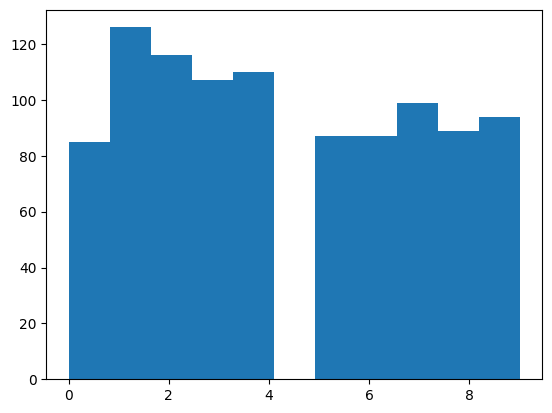

(array([ 85, 126, 116, 107, 110,  87,  87,  99,  89,  94], dtype=int64),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]))

In [4]:
plt.hist(eva_labels[:1000], bins='auto')
plt.show()

np.histogram(eva_labels[:1000])

In [5]:
error_correction = np.load("table_error_correction_2bit.npy")
print(error_correction)

[-7 -7 -7 -5 -7  5 -2 -1 -7  5  2  3  5  5  6  5 -7 -7  2 -1 -4 -1 -1 -1
  2  1  2  2  4  5  2 -1 -7 -5 -5 -5 -4 -3  6 -5  0  1  6 -5  6  5  6  6
 -4  1 -6 -5 -4 -4 -4 -1  1  1  2  1 -4  1  6  7 -7 -7 -2  3 -2 -3 -2 -2
  0  3  3  3  4  5 -2  3 -7 -7 -6 -7  4 -7 -2 -1  4 -7  2  3  4  4  4  7
  0 -3 -6 -5 -3 -3 -2 -3  0  0  0  3  0 -3  6  7 -6 -7 -6 -6 -4 -3 -6  7
  0  1 -6  7  4  7  7  7]


In [6]:
table_code_words = np.load("table_code_words.npy")
print(table_code_words)

[  0  81 114  35  52 101  70  23 104  57  26  75  92  13  46 127]


In [7]:
class Module:
    def __init__(self):
        self.modules = OrderedDict()

    def add_module(self, module, name: str):
        self.modules[name] = module

    def forward(self, input) -> np.ndarray:
        for module in self.modules:
            # print(f"module: {module}")
            input = self.modules[module].forward(input)

        return input


#------------------------------------------------------------------------------
#   FullyConnected class
#------------------------------------------------------------------------------
class FullyConnected(Module):
    def __init__(self, w, b, s_w, s_i, s_o, z_i, z_o, min_T, max_T):
        super(FullyConnected, self).__init__()
        self.W = w
        self.b = b
        self.z_i = z_i
        self.z_o = z_o
        self.m = s_i * s_w / s_o
        self.s_b = s_i * s_w
        self.min_T = min_T
        self.max_T = max_T
        print(self.W.shape)

    def forward(self, input: np.ndarray) -> np.ndarray:

        output_int8 = np.zeros((input.shape[0], self.W.shape[1]), dtype=np.int8)
        output = np.zeros((input.shape[0], self.W.shape[1]), dtype=np.int32)
        a2 = np.zeros((self.W.shape[1]), dtype=np.int32)

        for i in range(input.shape[0]):
            for k in range(self.W.shape[1]):
                for j in range(input.shape[1]):
                    a2[k] += np.int32(self.W[j][k])
                    output[i][k] += np.int32(input[i][j]) * np.int32(self.W[j][k])

                    # print(f'i = {input[i][j]}, W = {self.W[j][k]}, output_32 = {output[i][k]}, a2={a2[k]}')

                # print('-----------------')
                # print(f'z_o = {self.z_o}, m = {self.m}, o = {output[i][k]}, b = {self.b[k]}, a2 = {a2[k]}, z_i = {self.z_i}, zia2: {-self.z_i*a2[k]}')
                # print(f'output_before_saturate_cast = ',np.int32(self.z_o) + self.m * (-(np.int32(self.z_i)*a2[k]) + output[i][k] + self.b[k]))

                # output_int8[i][k] = tf.dtypes.saturate_cast(np.round(np.int32(self.z_o) + self.m * (-(np.int32(self.z_i)*a2[k]) + output[i][k] + self.b[k])), tf.int8)

                output_value = np.round(
                    np.int32(self.z_o) + self.m * (-(np.int32(self.z_i) * a2[k]) + output[i][k] + self.b[k]), 0)

                if output_value > self.max_T:
                    output_int8[i][k] = np.int8(self.max_T)
                elif output_value < self.min_T:
                    output_int8[i][k] = np.int8(self.min_T)
                else:
                    output_int8[i][k] = np.int8(output_value)

                # print('output_int8: ', output_int8[i][k])
                # print('-----------------')

        # print(f'input: {input} \noutput: {output_int8}\n-----------------\n-----------------')
        # print(f'input: {input.dtype} \noutput2: {output_int8.dtype}\n-----------------')

        return output_int8


#------------------------------------------------------------------------------
#   FullyConnected_fullprotection class
#------------------------------------------------------------------------------
class FullyConnected_fullprotection(Module):
    def __init__(self, w_encoded, b, s_w, s_i, s_o, z_i, z_o, min_T, max_T):
        super(FullyConnected_fullprotection, self).__init__()
        self.W_encoded = w_encoded
        self.b = b
        self.z_i = z_i
        self.z_o = z_o
        self.m = s_i * s_w / s_o
        self.s_b = s_i * s_w
        self.min_T = min_T
        self.max_T = max_T

    def forward(self, input: np.ndarray) -> np.ndarray:

        output_int8 = np.zeros((input.shape[0], self.W_encoded.shape[1]), dtype=np.int8)
        output = np.zeros((input.shape[0], self.W_encoded.shape[1]), dtype=np.int32)
        a2 = np.zeros((self.W_encoded.shape[1]), dtype=np.int32)

        for i in range(input.shape[0]):
            for k in range(self.W_encoded.shape[1]):
                for j in range(input.shape[1]):
                    a2[k] += np.int32(error_correction[self.W_encoded[j][k]])
                    output[i][k] += np.int32(input[i][j]) * np.int32(error_correction[self.W_encoded[j][k]])

                    # try:
                    #     output[i][k] += np.int32(table_lookup_multiplication[input[i][j]][self.W_encoded[j][k]])
                    # except:
                    #     try:
                    #         output[i][k] += np.int32(table_lookup_multiplication[self.W_encoded[j][k]][input[i][j]])
                    #     except:
                    #         print("except: error")

                    # print(f'i = {input[i][j]}, W = {self.W[j][k]}, output_32 = {output[i][k]}, a2={a2[k]}')

                # print('-----------------')
                # print(f'z_o = {self.z_o}, m = {self.m}, o = {output[i][k]}, b = {self.b[k]}, a2 = {a2[k]}, z_i = {self.z_i}, zia2: {-self.z_i*a2[k]}')
                # print(f'output_before_saturate_cast = ',np.int32(self.z_o) + self.m * (-(np.int32(self.z_i)*a2[k]) + output[i][k] + self.b[k]))

                # output_int8[i][k] = tf.dtypes.saturate_cast(np.round(np.int32(self.z_o) + self.m * (-(np.int32(self.z_i)*a2[k]) + output[i][k] + self.b[k])), tf.int8)

                output_value = np.round(
                    np.int32(self.z_o) + self.m * (-(np.int32(self.z_i) * a2[k]) + output[i][k] + self.b[k]), 0)

                if output_value > self.max_T:
                    output_int8[i][k] = np.int8(self.max_T)
                elif output_value < self.min_T:
                    output_int8[i][k] = np.int8(self.min_T)
                else:
                    output_int8[i][k] = np.int8(output_value)

                # print('output_int8: ', output_int8[i][k])
                # print('-----------------')

        # print(f'input: {input} \noutput: {output_int8}\n-----------------\n-----------------')
        # print(f'input: {input.dtype} \noutput2: {output_int8.dtype}\n-----------------')

        return output_int8


#------------------------------------------------------------------------------
#   FullyConnected_encoded class
#------------------------------------------------------------------------------
class FullyConnected_encoded(Module):
    def __init__(self, w, w_encoded, b, s_w, s_i, s_o, z_i, z_o, min_T, max_T):
        super(FullyConnected_encoded, self).__init__()
        self.W = w
        self.W_encoded = w_encoded
        self.b = b
        self.z_i = z_i
        self.z_o = z_o
        self.m = s_i * s_w / s_o
        self.s_b = s_i * s_w
        self.min_T = min_T
        self.max_T = max_T

    def forward(self, input: np.ndarray) -> np.ndarray:

        output_int8 = np.zeros((input.shape[0], self.W.shape[1]), dtype=np.int8)
        output = np.zeros((input.shape[0], self.W.shape[1]), dtype=np.int32)
        a2 = np.zeros((self.W.shape[1]), dtype=np.int32)

        for i in range(input.shape[0]):
            for k in range(self.W.shape[1]):
                for j in range(input.shape[1]):
                    a2[k] += np.int32(self.W[j][k])
                    # output[i][k] += np.int32(input[i][j]) * np.int32(self.W[j][k])
                    output[i][k] += np.int32(input[i][j]) * np.int32(error_correction[self.W_encoded[j][k]])
                    # output[i][k] += np.int32(table_lookup_multiplication_full[input[i][j]][self.W_encoded[j][k]])
                    # try:
                    #     output[i][k] += np.int32(error_correction[self.W_encoded[j][k]])
                    # except:
                    #     try:
                    #         output[i][k] += np.int32(error_correction[self.W_encoded[j][k]])
                    #     except:
                    #         print("except: error")

                    # print(f'i = {input[i][j]}, W = {self.W[j][k]}, output_32 = {output[i][k]}, a2={a2[k]}')

                # print('-----------------')
                # print(f'z_o = {self.z_o}, m = {self.m}, o = {output[i][k]}, b = {self.b[k]}, a2 = {a2[k]}, z_i = {self.z_i}, zia2: {-self.z_i*a2[k]}')
                # print(f'output_before_saturate_cast = ',np.int32(self.z_o) + self.m * (-(np.int32(self.z_i)*a2[k]) + output[i][k] + self.b[k]))

                # output_int8[i][k] = tf.dtypes.saturate_cast(np.round(np.int32(self.z_o) + self.m * (-(np.int32(self.z_i)*a2[k]) + output[i][k] + self.b[k])), tf.int8)

                output_value = np.round(
                    np.int32(self.z_o) + self.m * (-(np.int32(self.z_i) * a2[k]) + output[i][k] + self.b[k]), 0)

                if output_value > self.max_T:
                    output_int8[i][k] = np.int8(self.max_T)
                elif output_value < self.min_T:
                    output_int8[i][k] = np.int8(self.min_T)
                else:
                    output_int8[i][k] = np.int8(output_value)

                # print('output_int8: ', output_int8[i][k])
                # print('-----------------')

        # print(f'input: {input} \noutput: {output_int8}\n-----------------\n-----------------')
        # print(f'input: {input.dtype} \noutput2: {output_int8.dtype}\n-----------------')

        return output_int8


#------------------------------------------------------------------------------
#   Quantize class
#------------------------------------------------------------------------------
class Quantize(Module):
    def __init__(self, s, z_i, z_o, d_type):
        super(Quantize, self).__init__()
        self.z_i = z_i
        self.z_o = z_o
        self.s = s
        self.d_type = d_type

        # print(f'Quantize: z_i: {self.z_i} z_o: {self.z_o} s: {self.s} d_type: {self.d_type}')

    def forward(self, input: np.ndarray) -> np.ndarray:
        # converts from int8 to uint8 and vice versa
        if self.d_type is np.int8:
            arr_q = (input + 128).astype(np.uint8)
        elif self.d_type is np.uint8:
            arr_q = (input - 128).astype(np.int8)
        else:
            raise ValueError(f'input type is not supported: {input.dtype}')

        # print(f'input: {input} \noutput: {arr_q}\n-----------------\n-----------------')
        # print(f'input: {input.dtype} \noutput: {arr_q.dtype}\n-----------------')

        return arr_q

# Fastest way to calculate the dot product of two matrices in Python 
## f1 is fastest

In [8]:
class Module:
    def __init__(self):
        self.modules = OrderedDict()

    def add_module(self, module, name: str):
        self.modules[name] = module

    def forward(self, input) -> np.ndarray:
        for module in self.modules:
            # print(f"module: {module}")
            input = self.modules[module].forward(input)

        return input

#------------------------------------------------------------------------------
#   FullyConnected class
#------------------------------------------------------------------------------
class FullyConnected_f1(Module):
    def __init__(self, w, b, s_w, s_i, s_o, z_i, z_o, min_T, max_T):
        super(FullyConnected_f1, self).__init__()
        self.W = w.T
        self.b = b.T
        self.z_i = z_i
        self.z_o = z_o
        self.m = s_i * s_w / s_o
        self.min_T = min_T
        self.max_T = max_T

    def forward(self, input: np.ndarray) -> np.ndarray:

        output = np.matmul(np.int32(input), np.int32(self.W))
        a2 = np.sum(np.int32(self.W), axis=0)

        output_values = np.int32(self.z_o) + self.m * (-(np.int32(self.z_i) * a2) + output + self.b)

        output_values = np.where(output_values > self.max_T, self.max_T, output_values)
        output_values = np.where(output_values < self.min_T, self.min_T, output_values)

        return np.int8(np.round(output_values))


#------------------------------------------------------------------------------
#   FullyConnected_fullprotection class
#------------------------------------------------------------------------------
class FullyConnected_fullprotection_f1(Module):
    def __init__(self, w_encoded, b, s_w, s_i, s_o, z_i, z_o, min_T, max_T):
        super(FullyConnected_fullprotection_f1, self).__init__()
        self.W_encoded = w_encoded.T
        self.b = b.T
        self.z_i = z_i
        self.z_o = z_o
        self.m = s_i * s_w / s_o
        self.min_T = min_T
        self.max_T = max_T

    def forward(self, input: np.ndarray) -> np.ndarray:

        W_decoded = np.vectorize(error_correction.__getitem__)(self.W_encoded)
        output = np.matmul(np.int32(input), np.int32(W_decoded))
        a2 = np.sum(np.int32(W_decoded), axis=0)

        output_values = np.int32(self.z_o) + self.m * (-(np.int32(self.z_i) * a2) + output + self.b)

        output_values = np.where(output_values > self.max_T, self.max_T, output_values)
        output_values = np.where(output_values < self.min_T, self.min_T, output_values)

        return np.int8(np.round(output_values))

In [9]:
#------------------------------------------------------------------------------
#   FullyConnected class
#------------------------------------------------------------------------------
class FullyConnected_f2(Module):
    def __init__(self, w, b, s_w, s_i, s_o, z_i, z_o, min_T, max_T):
        super(FullyConnected_f2, self).__init__()
        self.W = w
        self.b = b
        self.z_i = z_i
        self.z_o = z_o
        self.m = s_i * s_w / s_o
        self.s_b = s_i * s_w
        self.min_T = min_T
        self.max_T = max_T
        print(self.W.shape)

    def forward(self, input: np.ndarray) -> np.ndarray:

        output_int8 = np.zeros((input.shape[0], self.W.shape[1]), dtype=np.int8)
        # print(input.shape, self.W.shape)
        output = np.matmul(np.int32(input), np.int32(self.W))

        for i in range(input.shape[0]):
            for k in range(self.W.shape[1]):
                a2 = np.sum(self.W[:, k])
                # for j in range(input.shape[1]):
                    # a2[k] += np.int32(self.W[j][k])
                    # output[i][k] += np.int32(input[i][j]) * np.int32(self.W[j][k])

                    # print(f'i = {input[i][j]}, W = {self.W[j][k]}, output_32 = {output[i][k]}, a2={a2[k]}')

                # print('-----------------')
                # print(f'z_o = {self.z_o}, m = {self.m}, o = {output[i][k]}, b = {self.b[k]}, a2 = {a2[k]}, z_i = {self.z_i}, zia2: {-self.z_i*a2[k]}')
                # print(f'output_before_saturate_cast = ',np.int32(self.z_o) + self.m * (-(np.int32(self.z_i)*a2[k]) + output[i][k] + self.b[k]))

                # output_int8[i][k] = tf.dtypes.saturate_cast(np.round(np.int32(self.z_o) + self.m * (-(np.int32(self.z_i)*a2[k]) + output[i][k] + self.b[k])), tf.int8)

                output_value = np.round(np.int32(self.z_o) + self.m * (-(np.int32(self.z_i) * a2) + output[i][k] + self.b[k]), 0)

                if output_value > self.max_T:
                    output_int8[i][k] = np.int8(self.max_T)
                elif output_value < self.min_T:
                    output_int8[i][k] = np.int8(self.min_T)
                else:
                    output_int8[i][k] = np.int8(output_value)

                # print('output_int8: ', output_int8[i][k])
                # print('-----------------')

        # print(f'input: {input} \noutput: {output_int8}\n-----------------\n-----------------')
        # print(f'input: {input.dtype} \noutput2: {output_int8.dtype}\n-----------------')

        return output_int8


#------------------------------------------------------------------------------
#   FullyConnected_fullprotection class
#------------------------------------------------------------------------------
error_correction_vec = np.vectorize(lambda x: error_correction[x])

class FullyConnected_fullprotection_f2(Module):
    def __init__(self, w_encoded, b, s_w, s_i, s_o, z_i, z_o, min_T, max_T):
        super(FullyConnected_fullprotection_f2, self).__init__()
        self.W_encoded = w_encoded
        self.b = b
        self.z_i = z_i
        self.z_o = z_o
        self.m = s_i * s_w / s_o
        self.s_b = s_i * s_w
        self.min_T = min_T
        self.max_T = max_T

    def forward(self, input: np.ndarray) -> np.ndarray:

        output_int8 = np.zeros((input.shape[0], self.W_encoded.shape[1]), dtype=np.int8)
        # W_decoded = np.zeros(self.W_encoded.shape, dtype=np.int8)


        # error_correction_vec = np.vectorize(lambda x: error_correction[x])
        W_decoded = error_correction_vec(self.W_encoded)

        # for i in range(self.W_encoded.shape[0]):
        #     for j in range(self.W_encoded.shape[1]):
        #         W_decoded[i][j] = error_correction[self.W_encoded[i][j]]

        output = np.matmul(np.int32(input), np.int32(W_decoded))


        for i in range(input.shape[0]):
            for k in range(self.W_encoded.shape[1]):
                a2 = np.sum(np.int32(W_decoded[:, k]))

                    # try:
                    #     output[i][k] += np.int32(table_lookup_multiplication[input[i][j]][self.W_encoded[j][k]])
                    # except:
                    #     try:
                    #         output[i][k] += np.int32(table_lookup_multiplication[self.W_encoded[j][k]][input[i][j]])
                    #     except:
                    #         print("except: error")

                    # print(f'i = {input[i][j]}, W = {self.W[j][k]}, output_32 = {output[i][k]}, a2={a2[k]}')

                # print('-----------------')
                # print(f'z_o = {self.z_o}, m = {self.m}, o = {output[i][k]}, b = {self.b[k]}, a2 = {a2[k]}, z_i = {self.z_i}, zia2: {-self.z_i*a2[k]}')
                # print(f'output_before_saturate_cast = ',np.int32(self.z_o) + self.m * (-(np.int32(self.z_i)*a2[k]) + output[i][k] + self.b[k]))

                # output_int8[i][k] = tf.dtypes.saturate_cast(np.round(np.int32(self.z_o) + self.m * (-(np.int32(self.z_i)*a2[k]) + output[i][k] + self.b[k])), tf.int8)

                output_value = np.round(
                    np.int32(self.z_o) + self.m * (-(np.int32(self.z_i) * a2) + output[i][k] + self.b[k]), 0)

                if output_value > self.max_T:
                    output_int8[i][k] = np.int8(self.max_T)
                elif output_value < self.min_T:
                    output_int8[i][k] = np.int8(self.min_T)
                else:
                    output_int8[i][k] = np.int8(output_value)

                # print('output_int8: ', output_int8[i][k])
                # print('-----------------')

        # print(f'input: {input} \noutput: {output_int8}\n-----------------\n-----------------')
        # print(f'input: {input.dtype} \noutput2: {output_int8.dtype}\n-----------------')

        return output_int8

In [10]:
#------------------------------------------------------------------------------
#   FullyConnected class
#------------------------------------------------------------------------------
class FullyConnected_f3(Module):
    def __init__(self, w, b, s_w, s_i, s_o, z_i, z_o, min_T, max_T):
        super(FullyConnected_f3, self).__init__()
        self.W = w
        self.b = b
        self.z_i = z_i
        self.z_o = z_o
        self.m = s_i * s_w / s_o
        self.s_b = s_i * s_w
        self.min_T = min_T
        self.max_T = max_T
        print(self.W.shape)

    def forward(self, input: np.ndarray) -> np.ndarray:

        output_int8 = np.zeros((input.shape[0], self.W.shape[0]), dtype=np.int8)

        for k in range(self.W.shape[0]):
            a2 = np.sum(self.W[k])
            for i in range(input.shape[0]):
                output = np.sum(np.int32(input[i]) * np.int32(self.W[k]))
                # for j in range(input.shape[1]):
                    # a2[k] += np.int32(self.W[j][k])
                    # output[i][k] += np.int32(input[i][j]) * np.int32(self.W[j][k])

                    # print(f'i = {input[i][j]}, W = {self.W[j][k]}, output_32 = {output[i][k]}, a2={a2[k]}')

                # print('-----------------')
                # print(f'z_o = {self.z_o}, m = {self.m}, o = {output[i][k]}, b = {self.b[k]}, a2 = {a2[k]}, z_i = {self.z_i}, zia2: {-self.z_i*a2[k]}')
                # print(f'output_before_saturate_cast = ',np.int32(self.z_o) + self.m * (-(np.int32(self.z_i)*a2[k]) + output[i][k] + self.b[k]))

                # output_int8[i][k] = tf.dtypes.saturate_cast(np.round(np.int32(self.z_o) + self.m * (-(np.int32(self.z_i)*a2[k]) + output[i][k] + self.b[k])), tf.int8)

                output_value = np.round(np.int32(self.z_o) + self.m * (-(np.int32(self.z_i) * a2) + output + self.b[k]), 0)

                if output_value > self.max_T:
                    output_int8[i][k] = np.int8(self.max_T)
                elif output_value < self.min_T:
                    output_int8[i][k] = np.int8(self.min_T)
                else:
                    output_int8[i][k] = np.int8(output_value)

                # print('output_int8: ', output_int8[i][k])
                # print('-----------------')

        # print(f'input: {input} \noutput: {output_int8}\n-----------------\n-----------------')
        # print(f'input: {input.dtype} \noutput2: {output_int8.dtype}\n-----------------')

        return output_int8


#------------------------------------------------------------------------------
#   FullyConnected_fullprotection class
#------------------------------------------------------------------------------
error_correction_vec = np.vectorize(lambda x: error_correction[x])

class FullyConnected_fullprotection_f3(Module):
    def __init__(self, w_encoded, b, s_w, s_i, s_o, z_i, z_o, min_T, max_T):
        super(FullyConnected_fullprotection_f3, self).__init__()
        self.W_encoded = w_encoded
        self.b = b
        self.z_i = z_i
        self.z_o = z_o
        self.m = s_i * s_w / s_o
        self.s_b = s_i * s_w
        self.min_T = min_T
        self.max_T = max_T

    def forward(self, input: np.ndarray) -> np.ndarray:

        W_decoded = error_correction_vec(self.W_encoded)

        output = np.matmul(np.int32(input), np.int32(W_decoded))

        a2 = np.sum(np.int32(W_decoded), axis=0)

        output_values = np.int32(self.z_o) + self.m * (-(np.int32(self.z_i) * a2) + output + self.b.reshape(1, -1))

        output_values = np.where(output_values > self.max_T, self.max_T, output_values)
        output_values = np.where(output_values < self.min_T, self.min_T, output_values)

        output_int8 = np.int8(np.round(output_values))

        return output_int8

In [11]:
#------------------------------------------------------------------------------
#   FullyConnected class
#------------------------------------------------------------------------------
class FullyConnected_f4(Module):
    def __init__(self, w, b, s_w, s_i, s_o, z_i, z_o, min_T, max_T):
        super(FullyConnected_f4, self).__init__()
        self.W = w
        self.b = b
        self.z_i = z_i
        self.z_o = z_o
        self.m = s_i * s_w / s_o
        self.s_b = s_i * s_w
        self.min_T = min_T
        self.max_T = max_T
        print(self.W.shape)

    def forward(self, input: np.ndarray) -> np.ndarray:

        output_int8 = np.zeros((input.shape[0], self.W.shape[1]), dtype=np.int8)
        output = np.matmul(np.int32(input), np.int32(self.W))

        for k in range(self.W.shape[1]):
            a2 = np.sum(self.W[:, k])
            for i in range(input.shape[0]):
                # output = np.sum(np.int32(input[i]) * np.int32(self.W[k]))
                # for j in range(input.shape[1]):
                    # a2[k] += np.int32(self.W[j][k])
                    # output[i][k] += np.int32(input[i][j]) * np.int32(self.W[j][k])

                    # print(f'i = {input[i][j]}, W = {self.W[j][k]}, output_32 = {output[i][k]}, a2={a2[k]}')

                # print('-----------------')
                # print(f'z_o = {self.z_o}, m = {self.m}, o = {output[i][k]}, b = {self.b[k]}, a2 = {a2[k]}, z_i = {self.z_i}, zia2: {-self.z_i*a2[k]}')
                # print(f'output_before_saturate_cast = ',np.int32(self.z_o) + self.m * (-(np.int32(self.z_i)*a2[k]) + output[i][k] + self.b[k]))

                # output_int8[i][k] = tf.dtypes.saturate_cast(np.round(np.int32(self.z_o) + self.m * (-(np.int32(self.z_i)*a2[k]) + output[i][k] + self.b[k])), tf.int8)

                output_value = np.round(np.int32(self.z_o) + self.m * (-(np.int32(self.z_i) * a2) + output[i][k] + self.b[k]), 0)

                if output_value > self.max_T:
                    output_int8[i][k] = np.int8(self.max_T)
                elif output_value < self.min_T:
                    output_int8[i][k] = np.int8(self.min_T)
                else:
                    output_int8[i][k] = np.int8(output_value)

                # print('output_int8: ', output_int8[i][k])
                # print('-----------------')

        # print(f'input: {input} \noutput: {output_int8}\n-----------------\n-----------------')
        # print(f'input: {input.dtype} \noutput2: {output_int8.dtype}\n-----------------')

        return output_int8


#------------------------------------------------------------------------------
#   FullyConnected_fullprotection class
#------------------------------------------------------------------------------
error_correction_vec = np.vectorize(lambda x: error_correction[x])

class FullyConnected_fullprotection_f4(Module):
    def __init__(self, w_encoded, b, s_w, s_i, s_o, z_i, z_o, min_T, max_T):
        super(FullyConnected_fullprotection_f4, self).__init__()
        self.W_encoded = w_encoded
        self.b = b
        self.z_i = z_i
        self.z_o = z_o
        self.m = s_i * s_w / s_o
        self.s_b = s_i * s_w
        self.min_T = min_T
        self.max_T = max_T

    def forward(self, input: np.ndarray) -> np.ndarray:

        output_int8 = np.zeros((input.shape[0], self.W_encoded.shape[1]), dtype=np.int8)
        # W_decoded = np.zeros(self.W_encoded.shape, dtype=np.int8)

        # for i in range(self.W_encoded.shape[0]):
        #     for j in range(self.W_encoded.shape[1]):
        #         W_decoded[i][j] = error_correction[self.W_encoded[i][j]]

        W_decoded = error_correction_vec(self.W_encoded)

        output = np.matmul(np.int32(input), np.int32(W_decoded))

        for k in range(self.W_encoded.shape[1]):
            a2 = np.sum(np.int32(W_decoded[:, k]))

            for i in range(input.shape[0]):

                    # try:
                    #     output[i][k] += np.int32(table_lookup_multiplication[input[i][j]][self.W_encoded[j][k]])
                    # except:
                    #     try:
                    #         output[i][k] += np.int32(table_lookup_multiplication[self.W_encoded[j][k]][input[i][j]])
                    #     except:
                    #         print("except: error")

                    # print(f'i = {input[i][j]}, W = {self.W[j][k]}, output_32 = {output[i][k]}, a2={a2[k]}')

                # print('-----------------')
                # print(f'z_o = {self.z_o}, m = {self.m}, o = {output[i][k]}, b = {self.b[k]}, a2 = {a2[k]}, z_i = {self.z_i}, zia2: {-self.z_i*a2[k]}')
                # print(f'output_before_saturate_cast = ',np.int32(self.z_o) + self.m * (-(np.int32(self.z_i)*a2[k]) + output[i][k] + self.b[k]))

                # output_int8[i][k] = tf.dtypes.saturate_cast(np.round(np.int32(self.z_o) + self.m * (-(np.int32(self.z_i)*a2[k]) + output[i][k] + self.b[k])), tf.int8)

                output_value = np.round(
                    np.int32(self.z_o) + self.m * (-(np.int32(self.z_i) * a2) + output[i][k] + self.b[k]), 0)

                if output_value > self.max_T:
                    output_int8[i][k] = np.int8(self.max_T)
                elif output_value < self.min_T:
                    output_int8[i][k] = np.int8(self.min_T)
                else:
                    output_int8[i][k] = np.int8(output_value)

                # print('output_int8: ', output_int8[i][k])
                # print('-----------------')

        # print(f'input: {input} \noutput: {output_int8}\n-----------------\n-----------------')
        # print(f'input: {input.dtype} \noutput2: {output_int8.dtype}\n-----------------')

        return output_int8

In [12]:
# Weight quantization
# https://www.tensorflow.org/api_docs/python/tf/quantization/quantize
def weight_scaling_factor(a, b, min_T, max_T):
    s_a = a / min_T
    s_b = b / max_T

    if s_a > s_b:
        return s_a, a, max_T * s_a
    else:
        return s_b, min_T * s_b, b

def clamp(r,a,b):
    return min(max(r, a), b)

clamp_vec = np.vectorize(clamp)

def weight_quan(r, a, b, min_T, s):

    q_value = np.round((clamp(r,a,b) - a) / s) + min_T

    # print(f'q_value: {q_value}')
    # print(f'q_value_2: {np.round((clamp(r,a,b)) / s)}')
    # print(f'q_value_3: {np.int8(np.round((clamp(r,a,b)) / s))}')

    # z = 0
    # r = s * (q_value - z)

    # print(f'r: {r}')

    return q_value

def weight_arr_quan(input_arr, min_T, max_T):

    a, b = np.min(input_arr), np.max(input_arr)
    s, a, b = weight_scaling_factor(a, b, min_T, max_T)

    # out_arr = np.zeros(input_arr.shape, dtype=np.int8).T
    #
    # for i in range(input_arr.shape[0]):
    #     for j in range(input_arr.shape[1]):
    #         out_arr[j][i] = weight_quan(input_arr[i][j], a, b, min_T, s)

    out_arr = np.int8(np.round(((clamp_vec(input_arr, a, b) - a) / s) + min_T)).T

    return s, 0, out_arr

############################################################################################################

# Activation quantization

def activation_scaling_factor(a, b, n):
   return (b - a) / (n - 1)

def activation_scale_zero_point(input_array, n):
    a, b = np.min(input_array), np.max(input_array)
    s = (b - a) / (n - 1)
    q_value = np.round((0 - a) / s) - n/2 #zero point

    return s, q_value

def activation_quan(r, a, b, n, s, z):

    q_value = np.round((clamp(r,a,b) - a) / s) - n/2

    # print(f'q_value: {q_value}')

    # r = s * (q_value - z)
    # print(f'r: {r}')

    return q_value

############################################################################################################

# Bias quantization

def bias_quan(r, s_w, s_i):
    return np.round(r / (s_i * s_w))

def bias_arr_quan(arr, s_w, s_i):

    # arr = np.array([bias_quan(r, s_w, s_i) for r in arr], dtype=np.int32)
    # s = s_w * s_i

    s = s_w * s_i
    out_arr = np.int32(np.round(arr / s))

    return s, 0, out_arr

# NN 200-200-200-10 architecture

In [13]:
# Define a simple sequential model
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(200, activation='relu', input_dim=input_size),
        tf.keras.layers.Dense(200, activation='relu'),
        tf.keras.layers.Dense(200, activation='relu'),
        tf.keras.layers.Dense(10)
    ])

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    return model


# Create a basic model instance
model = create_model()
# model.fit(
#     train_images_float32,
#     train_labels,
#     epochs=10,
#     batch_size=64,
#     validation_data=(eva_images_float32, eva_labels)
# )

tflite_models_dir = pathlib.Path("models")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

float_weights_path = r"./models/mnist_float_nn_tf_layers4_neurons_200-200-200-10/mnist_float_weights"

# Save the model:
float_weights_model_file = tflite_models_dir / "mnist_float_nn_tf_layers4_neurons_200-200-200-10/mnist_float_weights"
float_weights_model_file_index = tflite_models_dir / "mnist_float_nn_tf_layers4_neurons_200-200-200-10/mnist_float_weights.index"
if not float_weights_model_file_index.is_file():
    model.save_weights(float_weights_model_file)
    print("Float weights saved to: ", float_weights_model_file)


In [14]:
model = create_model()
model.load_weights(float_weights_model_file)

In [15]:
# Define a new model that outputs the intermediate layer
intermediate_model_1 = tf.keras.Model(inputs=model.input, outputs=model.layers[0].output)
intermediate_model_2 = tf.keras.Model(inputs=model.input, outputs=model.layers[1].output)
intermediate_model_3 = tf.keras.Model(inputs=model.input, outputs=model.layers[2].output)

# Get the intermediate output for the entire input dataset
intermediate_output_1_float32 = intermediate_model_1.predict(train_images_float32)
intermediate_output_2_float32 = intermediate_model_2.predict(train_images_float32)
intermediate_output_3_float32 = intermediate_model_3.predict(train_images_float32)

outputs_float32 = model.predict(train_images_float32)

1875/1875 [==============================] - 2s 838us/step


In [16]:
int4_s_w1, int4_z_w1, int4_w1 = weight_arr_quan(model.layers[0].get_weights()[0], -7, 7)
int4_s_i1, int4_z_i1 = activation_scale_zero_point(train_images_float32, 16)
int4_s_b1, int4_z_b1, int4_b1 = bias_arr_quan(model.layers[0].get_weights()[1], int4_s_w1, int4_s_i1)

int4_s_w2, int4_z_w2, int4_w2 = weight_arr_quan(model.layers[1].get_weights()[0], -7, 7)
int4_s_i2, int4_z_i2 = activation_scale_zero_point(intermediate_output_1_float32, 16)
int4_s_b2, int4_z_b2, int4_b2 = bias_arr_quan(model.layers[1].get_weights()[1], int4_s_w2, int4_s_i2)

int4_s_w3, int4_z_w3, int4_w3 = weight_arr_quan(model.layers[2].get_weights()[0], -7, 7)
int4_s_i3, int4_z_i3 = activation_scale_zero_point(intermediate_output_2_float32, 16)
int4_s_b3, int4_z_b3, int4_b3 = bias_arr_quan(model.layers[2].get_weights()[1], int4_s_w3, int4_s_i3)

int4_s_w4, int4_z_w4, int4_w4 = weight_arr_quan(model.layers[3].get_weights()[0], -7, 7)
int4_s_i4, int4_z_i4 = activation_scale_zero_point(intermediate_output_3_float32, 16)
int4_s_b4, int4_z_b4, int4_b4 = bias_arr_quan(model.layers[3].get_weights()[1], int4_s_w4, int4_s_i4)

int4_s_o1, int4_z_o1 = int4_s_i2, int4_z_i2
int4_s_o2, int4_z_o2 = int4_s_i3, int4_z_i3
int4_s_o3, int4_z_o3 = int4_s_i4, int4_z_i4
int4_s_o4, int4_z_o4 = activation_scale_zero_point(outputs_float32, 16)

model_int4 = Module()
model_int4.add_module(FullyConnected(int4_w1.T, int4_b1, int4_s_w1, int4_s_i1, int4_s_o1, int4_z_i1, int4_z_o1, -8, 7), 'l1')
model_int4.add_module(FullyConnected(int4_w2.T, int4_b2, int4_s_w2, int4_s_i2, int4_s_o2, int4_z_i2, int4_z_o2, -8, 7), 'l2')
model_int4.add_module(FullyConnected(int4_w3.T, int4_b3, int4_s_w3, int4_s_i3, int4_s_o3, int4_z_i3, int4_z_o3, -8, 7), 'l3')
model_int4.add_module(FullyConnected(int4_w4.T, int4_b4, int4_s_w4, int4_s_i4, int4_s_o4, int4_z_i4, int4_z_o4, -8, 7), 'l4')

(784, 200)
(200, 200)
(200, 200)
(200, 10)


In [17]:
model_int4_f1 = Module()
model_int4_f1.add_module(FullyConnected_f1(int4_w1, int4_b1, int4_s_w1, int4_s_i1, int4_s_o1, int4_z_i1, int4_z_o1, -8, 7), 'l1')
model_int4_f1.add_module(FullyConnected_f1(int4_w2, int4_b2, int4_s_w2, int4_s_i2, int4_s_o2, int4_z_i2, int4_z_o2, -8, 7), 'l2')
model_int4_f1.add_module(FullyConnected_f1(int4_w3, int4_b3, int4_s_w3, int4_s_i3, int4_s_o3, int4_z_i3, int4_z_o3, -8, 7), 'l3')
model_int4_f1.add_module(FullyConnected_f1(int4_w4, int4_b4, int4_s_w4, int4_s_i4, int4_s_o4, int4_z_i4, int4_z_o4, -8, 7), 'l4')

In [18]:
model_int4_f2 = Module()
model_int4_f2.add_module(FullyConnected_f2(int4_w1.T, int4_b1, int4_s_w1, int4_s_i1, int4_s_o1, int4_z_i1, int4_z_o1, -8, 7), 'l1')
model_int4_f2.add_module(FullyConnected_f2(int4_w2.T, int4_b2, int4_s_w2, int4_s_i2, int4_s_o2, int4_z_i2, int4_z_o2, -8, 7), 'l2')
model_int4_f2.add_module(FullyConnected_f2(int4_w3.T, int4_b3, int4_s_w3, int4_s_i3, int4_s_o3, int4_z_i3, int4_z_o3, -8, 7), 'l3')
model_int4_f2.add_module(FullyConnected_f2(int4_w4.T, int4_b4, int4_s_w4, int4_s_i4, int4_s_o4, int4_z_i4, int4_z_o4, -8, 7), 'l4')

(784, 200)
(200, 200)
(200, 200)
(200, 10)


In [19]:
model_int4_f3 = Module()
model_int4_f3.add_module(FullyConnected_f3(int4_w1, int4_b1, int4_s_w1, int4_s_i1, int4_s_o1, int4_z_i1, int4_z_o1, -8, 7), 'l1')
model_int4_f3.add_module(FullyConnected_f3(int4_w2, int4_b2, int4_s_w2, int4_s_i2, int4_s_o2, int4_z_i2, int4_z_o2, -8, 7), 'l2')
model_int4_f3.add_module(FullyConnected_f3(int4_w3, int4_b3, int4_s_w3, int4_s_i3, int4_s_o3, int4_z_i3, int4_z_o3, -8, 7), 'l3')
model_int4_f3.add_module(FullyConnected_f3(int4_w4, int4_b4, int4_s_w4, int4_s_i4, int4_s_o4, int4_z_i4, int4_z_o4, -8, 7), 'l4')

(200, 784)
(200, 200)
(200, 200)
(10, 200)


In [20]:
model_int4_f4 = Module()
model_int4_f4.add_module(FullyConnected_f4(int4_w1.T, int4_b1, int4_s_w1, int4_s_i1, int4_s_o1, int4_z_i1, int4_z_o1, -8, 7), 'l1')
model_int4_f4.add_module(FullyConnected_f4(int4_w2.T, int4_b2, int4_s_w2, int4_s_i2, int4_s_o2, int4_z_i2, int4_z_o2, -8, 7), 'l2')
model_int4_f4.add_module(FullyConnected_f4(int4_w3.T, int4_b3, int4_s_w3, int4_s_i3, int4_s_o3, int4_z_i3, int4_z_o3, -8, 7), 'l3')
model_int4_f4.add_module(FullyConnected_f4(int4_w4.T, int4_b4, int4_s_w4, int4_s_i4, int4_s_o4, int4_z_i4, int4_z_o4, -8, 7), 'l4')

(784, 200)
(200, 200)
(200, 200)
(200, 10)


In [21]:
int4_w1_encoded = np.zeros(int4_w1.shape, dtype=np.int8)
int4_w2_encoded = np.zeros(int4_w2.shape, dtype=np.int8)
int4_w3_encoded = np.zeros(int4_w3.shape, dtype=np.int8)
int4_w4_encoded = np.zeros(int4_w4.shape, dtype=np.int8)

for i in range(int4_w1.shape[0]):
    for j in range(int4_w1.shape[1]):
        int4_w1_encoded[i][j] = table_code_words[(int4_w1[i][j] + 8)]

for i in range(int4_w2.shape[0]):
    for j in range(int4_w2.shape[1]):
        int4_w2_encoded[i][j] = table_code_words[(int4_w2[i][j] + 8)]

for i in range(int4_w3.shape[0]):
    for j in range(int4_w3.shape[1]):
        int4_w3_encoded[i][j] = table_code_words[(int4_w3[i][j] + 8)]

for i in range(int4_w4.shape[0]):
    for j in range(int4_w4.shape[1]):
        int4_w4_encoded[i][j] = table_code_words[(int4_w4[i][j] + 8)]

In [22]:
model_int4_fullprotection = Module()
model_int4_fullprotection.add_module(FullyConnected_fullprotection(int4_w1_encoded.T, int4_b1, int4_s_w1, int4_s_i1, int4_s_o1, int4_z_i1, int4_z_o1, -8, 7), 'l1')
model_int4_fullprotection.add_module(FullyConnected_fullprotection(int4_w2_encoded.T, int4_b2, int4_s_w2, int4_s_i2, int4_s_o2, int4_z_i2, int4_z_o2, -8, 7), 'l2')
model_int4_fullprotection.add_module(FullyConnected_fullprotection(int4_w3_encoded.T, int4_b3, int4_s_w3, int4_s_i3, int4_s_o3, int4_z_i3, int4_z_o3, -8, 7), 'l3')
model_int4_fullprotection.add_module(FullyConnected_fullprotection(int4_w4_encoded.T, int4_b4, int4_s_w4, int4_s_i4, int4_s_o4, int4_z_i4, int4_z_o4, -8, 7), 'l4')

In [23]:
model_int4_fullprotection_f1 = Module()
model_int4_fullprotection_f1.add_module(FullyConnected_fullprotection_f1(int4_w1_encoded, int4_b1, int4_s_w1, int4_s_i1, int4_s_o1, int4_z_i1, int4_z_o1, -8, 7), 'l1')
model_int4_fullprotection_f1.add_module(FullyConnected_fullprotection_f1(int4_w2_encoded, int4_b2, int4_s_w2, int4_s_i2, int4_s_o2, int4_z_i2, int4_z_o2, -8, 7), 'l2')
model_int4_fullprotection_f1.add_module(FullyConnected_fullprotection_f1(int4_w3_encoded, int4_b3, int4_s_w3, int4_s_i3, int4_s_o3, int4_z_i3, int4_z_o3, -8, 7), 'l3')
model_int4_fullprotection_f1.add_module(FullyConnected_fullprotection_f1(int4_w4_encoded, int4_b4, int4_s_w4, int4_s_i4, int4_s_o4, int4_z_i4, int4_z_o4, -8, 7), 'l4')


In [24]:
model_int4_fullprotection_f2 = Module()
model_int4_fullprotection_f2.add_module(FullyConnected_fullprotection_f2(int4_w1_encoded.T, int4_b1, int4_s_w1, int4_s_i1, int4_s_o1, int4_z_i1, int4_z_o1, -8, 7), 'l1')
model_int4_fullprotection_f2.add_module(FullyConnected_fullprotection_f2(int4_w2_encoded.T, int4_b2, int4_s_w2, int4_s_i2, int4_s_o2, int4_z_i2, int4_z_o2, -8, 7), 'l2')
model_int4_fullprotection_f2.add_module(FullyConnected_fullprotection_f2(int4_w3_encoded.T, int4_b3, int4_s_w3, int4_s_i3, int4_s_o3, int4_z_i3, int4_z_o3, -8, 7), 'l3')
model_int4_fullprotection_f2.add_module(FullyConnected_fullprotection_f2(int4_w4_encoded.T, int4_b4, int4_s_w4, int4_s_i4, int4_s_o4, int4_z_i4, int4_z_o4, -8, 7), 'l4')

In [25]:
model_int4_fullprotection_f3 = Module()
model_int4_fullprotection_f3.add_module(FullyConnected_fullprotection_f3(int4_w1_encoded.T, int4_b1, int4_s_w1, int4_s_i1, int4_s_o1, int4_z_i1, int4_z_o1, -8, 7), 'l1')
model_int4_fullprotection_f3.add_module(FullyConnected_fullprotection_f3(int4_w2_encoded.T, int4_b2, int4_s_w2, int4_s_i2, int4_s_o2, int4_z_i2, int4_z_o2, -8, 7), 'l2')
model_int4_fullprotection_f3.add_module(FullyConnected_fullprotection_f3(int4_w3_encoded.T, int4_b3, int4_s_w3, int4_s_i3, int4_s_o3, int4_z_i3, int4_z_o3, -8, 7), 'l3')
model_int4_fullprotection_f3.add_module(FullyConnected_fullprotection_f3(int4_w4_encoded.T, int4_b4, int4_s_w4, int4_s_i4, int4_s_o4, int4_z_i4, int4_z_o4, -8, 7), 'l4')

In [26]:
model_int4_fullprotection_f4 = Module()
model_int4_fullprotection_f4.add_module(FullyConnected_fullprotection_f4(int4_w1_encoded.T, int4_b1, int4_s_w1, int4_s_i1, int4_s_o1, int4_z_i1, int4_z_o1, -8, 7), 'l1')
model_int4_fullprotection_f4.add_module(FullyConnected_fullprotection_f4(int4_w2_encoded.T, int4_b2, int4_s_w2, int4_s_i2, int4_s_o2, int4_z_i2, int4_z_o2, -8, 7), 'l2')
model_int4_fullprotection_f4.add_module(FullyConnected_fullprotection_f4(int4_w3_encoded.T, int4_b3, int4_s_w3, int4_s_i3, int4_s_o3, int4_z_i3, int4_z_o3, -8, 7), 'l3')
model_int4_fullprotection_f4.add_module(FullyConnected_fullprotection_f4(int4_w4_encoded.T, int4_b4, int4_s_w4, int4_s_i4, int4_s_o4, int4_z_i4, int4_z_o4, -8, 7), 'l4')

In [27]:
def representative_data_gen():
    for input_value in train_images_float32:
        yield [input_value]


converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Set the input and output tensors to int8
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Patrik\AppData\Local\Temp\tmpx6569ewl\assets


d:\dp\dp\code\openvino_notebooks_py37\venv\lib\site-packages\tensorflow\lite\python\convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [28]:
tflite_models_dir = pathlib.Path("models")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

model_path = r"models/mnist_int8_tflite_model_layers4_neurons200-200-200-10.tflite"

# Save the model:
int8_tflite_model_file = tflite_models_dir / "mnist_int8_tflite_model_layers4_neurons200-200-200-10.tflite"
if not int8_tflite_model_file.is_file():
    int8_tflite_model_file.write_bytes(tflite_model_quant)
    print("Model saved to: ", int8_tflite_model_file)

In [29]:
tflite_file = pathlib.Path('.\models\mnist_int8_tflite_model_layers4_neurons200-200-200-10.tflite')
interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
interpreter.allocate_tensors()

input_index_interpreter = interpreter.get_input_details()[0]["index"]
output_index_interpreter = interpreter.get_output_details()[0]["index"]
input_details_interpreter = interpreter.get_input_details()[0]
input_scale_interpreter, input_zero_point_interpreter = input_details_interpreter["quantization"]

def run_tflite_model(interpreter, input):

    test_image = input / input_scale_interpreter + input_zero_point_interpreter

    test_image = np.expand_dims(test_image, axis=0).astype(input_details_interpreter["dtype"])

    eva_time_all = time.time()
    interpreter.set_tensor(input_index_interpreter, test_image)
    eva_time_invoke = time.time()
    interpreter.invoke()
    eva_time_invoke = time.time() - eva_time_invoke
    output = interpreter.get_tensor(output_index_interpreter)
    eva_time_all = time.time() - eva_time_all

    return output, eva_time_invoke, eva_time_all

In [30]:
dif = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0])

correct_int4 = 0
correct_int4_f1 = 0
correct_int4_f2 = 0
correct_int4_f3 = 0
correct_int4_f4 = 0
correct_int4_fullprotection = 0
correct_int4_fullprotection_f1 = 0
correct_int4_fullprotection_f2 = 0
correct_int4_fullprotection_f3 = 0
correct_int4_fullprotection_f4 = 0
correct_int8_tf = 0

mistakes_int4 = np.array([])
mistakes_int4_f1 = np.array([])
mistakes_int4_f2 = np.array([])
mistakes_int4_f3 = np.array([])
mistakes_int4_f4 = np.array([])
mistakes_int4_fullprotection = np.array([])
mistakes_int4_fullprotection_f1 = np.array([])
mistakes_int4_fullprotection_f2 = np.array([])
mistakes_int4_fullprotection_f3 = np.array([])
mistakes_int4_fullprotection_f4 = np.array([])
mistakes_int8_tf = np.array([])

eva_time = np.array([])
eva_time_f1 = np.array([])
eva_time_f2 = np.array([])
eva_time_f3 = np.array([])
eva_time_f4 = np.array([])
eva_time_fullprotection = np.array([])
eva_time_fullprotection_f1 = np.array([])
eva_time_fullprotection_f2 = np.array([])
eva_time_fullprotection_f3 = np.array([])
eva_time_fullprotection_f4 = np.array([])
eva_time_int8_tf_invoke = np.array([])
eva_time_int8_tf_all = np.array([])

start_time = time.time()

for i in range(eva_images_float32.shape[0]):
# for i in range(1000):

    if i % 1000 == 0 and i != 0:

        hours, rem = divmod(time.time()-round_time, 3600)
        minutes, seconds = divmod(rem, 60)

        print(f"done {i}")
        print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
        # print("acc_int4                   : ", correct_int4 / i)
        print("acc_int4_f1                : ", correct_int4_f1 / i)
        # print("acc_int4_f2                : ", correct_int4_f2 / i)
        # print("acc_int4_f3                : ", correct_int4_f3 / i)
        # print("acc_int4_f4                : ", correct_int4_f4 / i)
        # print("acc_int4_fullprotection    : ", correct_int4_fullprotection / i)
        print("acc_int4_fullprotection_f1 : ", correct_int4_fullprotection_f1 / i)
        # print("acc_int4_fullprotection_f2 : ", correct_int4_fullprotection_f2 / i)
        # print("acc_int4_fullprotection_f3 : ", correct_int4_fullprotection_f3 / i)
        # print("acc_int4_fullprotection_f4 : ", correct_int4_fullprotection_f4 / i)
        print("acc_int8_tf                : ", correct_int8_tf / i)


        # print("dif_f1: ", dif[0] / i)
        # print("dif_f2: ", dif[1] / i)
        # print("dif_f3: ", dif[2] / i)
        # print("dif_f4: ", dif[3] / i)
        # print("dif_fullprotection: ", dif[4] / i)
        # print("dif_fullprotection_f1: ", dif[5] / i)
        # print("dif_fullprotection_f2: ", dif[6] / i)
        # print("dif_fullprotection_f3: ", dif[7] / i)
        # print("dif_fullprotection_f4: ", dif[8] / i)


        # print(f'eva_time                    : {np.mean(eva_time)}')
        print(f'eva_time_f1                 : {np.mean(eva_time_f1)}')
        # print(f'eva_time_f2                 : {np.mean(eva_time_f2)}')
        # print(f'eva_time_f3                 : {np.mean(eva_time_f3)}')
        # print(f'eva_time_f4                 : {np.mean(eva_time_f4)}')
        # print(f'eva_time_fullprotection     : {np.mean(eva_time_fullprotection)}')
        print(f'eva_time_fullprotection_f1  : {np.mean(eva_time_fullprotection_f1)}')
        # print(f'eva_time_fullprotection_f2  : {np.mean(eva_time_fullprotection_f2)}')
        # print(f'eva_time_fullprotection_f3  : {np.mean(eva_time_fullprotection_f3)}')
        # print(f'eva_time_fullprotection_f4  : {np.mean(eva_time_fullprotection_f4)}')
        print(f'eva_time_int8_tf_invoke     : {np.mean(eva_time_int8_tf_invoke)}')
        print(f'eva_time_int8_tf_all        : {np.mean(eva_time_int8_tf_all)}')
        print("----------------------------------------------------------------------------")

    if i % 1000 == 0:
        round_time = time.time()

    input_int4 = eva_images_float32[i]
    input_int4 = input_int4 / int4_s_i1 + int4_z_i1
    input_int4 = np.expand_dims(input_int4, axis=0).astype(np.int8)

    input_int8_tf = eva_images_float32[i]

    # eva_time_s = time.time()
    # output_model_int4 = model_int4.forward(input_int4)
    # eva_time = np.append(eva_time, time.time() - eva_time_s)

    eva_time_s = time.time()
    output_model_int4_f1 = model_int4_f1.forward(input_int4)
    eva_time_f1 = np.append(eva_time_f1, time.time() - eva_time_s)

    # eva_time_s = time.time()
    # output_model_int4_f2 = model_int4_f2.forward(input_int4)
    # eva_time_f2 = np.append(eva_time_f2, time.time() - eva_time_s)
    #
    # eva_time_s = time.time()
    # output_model_int4_f3 = model_int4_f3.forward(input_int4)
    # eva_time_f3 = np.append(eva_time_f3, time.time() - eva_time_s)
    #
    # eva_time_s = time.time()
    # output_model_int4_f4 = model_int4_f4.forward(input_int4)
    # eva_time_f4 = np.append(eva_time_f4, time.time() - eva_time_s)
    #
    # eva_time_s = time.time()
    # output_model_int4_fullprotection = model_int4_fullprotection.forward(input_int4)
    # eva_time_fullprotection = np.append(eva_time_fullprotection, time.time() - eva_time_s)

    eva_time_s = time.time()
    output_model_int4_fullprotection_f1 = model_int4_fullprotection_f1.forward(input_int4)
    eva_time_fullprotection_f1 = np.append(eva_time_fullprotection_f1, time.time() - eva_time_s)

    # eva_time_s = time.time()
    # output_model_int4_fullprotection_f2 = model_int4_fullprotection_f2.forward(input_int4)
    # eva_time_fullprotection_f2 = np.append(eva_time_fullprotection_f2, time.time() - eva_time_s)
    #
    # eva_time_s = time.time()
    # output_model_int4_fullprotection_f3 = model_int4_fullprotection_f3.forward(input_int4)
    # eva_time_fullprotection_f3 = np.append(eva_time_fullprotection_f3, time.time() - eva_time_s)
    #
    # eva_time_s = time.time()
    # output_model_int4_fullprotection_f4 = model_int4_fullprotection_f4.forward(input_int4)
    # eva_time_fullprotection_f4 = np.append(eva_time_fullprotection_f4, time.time() - eva_time_s)

    output_model_int8_tf, time_tf_invoke, time_tf_all = run_tflite_model(interpreter, input_int8_tf)
    eva_time_int8_tf_invoke = np.append(eva_time_int8_tf_invoke, time_tf_invoke)
    eva_time_int8_tf_all = np.append(eva_time_int8_tf_all, time_tf_all)

    # dif[0] += np.sum(np.abs(output_model_int4 - output_model_int4_f1))
    # dif[1] += np.sum(np.abs(output_model_int4 - output_model_int4_f2))
    # dif[2] += np.sum(np.abs(output_model_int4 - output_model_int4_f3))
    # dif[3] += np.sum(np.abs(output_model_int4 - output_model_int4_f4))
    # dif[4] += np.sum(np.abs(output_model_int4 - output_model_int4_fullprotection))
    # dif[5] += np.sum(np.abs(output_model_int4 - output_model_int4_fullprotection_f1))
    # dif[6] += np.sum(np.abs(output_model_int4 - output_model_int4_fullprotection_f2))
    # dif[7] += np.sum(np.abs(output_model_int4 - output_model_int4_fullprotection_f3))
    # dif[8] += np.sum(np.abs(output_model_int4 - output_model_int4_fullprotection_f4))

    # answer_int4 = np.argmax(output_model_int4)
    answer_int4_f1 = np.argmax(output_model_int4_f1)
    # answer_int4_f2 = np.argmax(output_model_int4_f2)
    # answer_int4_f3 = np.argmax(output_model_int4_f3)
    # answer_int4_f4 = np.argmax(output_model_int4_f4)
    # answer_int4_fullprotection = np.argmax(output_model_int4_fullprotection)
    answer_int4_fullprotection_f1 = np.argmax(output_model_int4_fullprotection_f1)
    # answer_int4_fullprotection_f2 = np.argmax(output_model_int4_fullprotection_f2)
    # answer_int4_fullprotection_f3 = np.argmax(output_model_int4_fullprotection_f3)
    # answer_int4_fullprotection_f4 = np.argmax(output_model_int4_fullprotection_f4)
    answer_int8_tf = np.argmax(output_model_int8_tf)


    # if answer_int4 == eva_labels[i]:
    #     correct_int4 += 1
    # else:
    #     mistakes_int4 = np.append(mistakes_int4, i)

    if answer_int4_f1 == eva_labels[i]:
        correct_int4_f1 += 1
    else:
        mistakes_int4_f1 = np.append(mistakes_int4_f1, i)

    # if answer_int4_f2 == eva_labels[i]:
    #     correct_int4_f2 += 1
    # else:
    #     mistakes_int4_f2 = np.append(mistakes_int4_f2, i)
    #
    # if answer_int4_f3 == eva_labels[i]:
    #     correct_int4_f3 += 1
    # else:
    #     mistakes_int4_f3 = np.append(mistakes_int4_f3, i)
    #
    # if answer_int4_f4 == eva_labels[i]:
    #     correct_int4_f4 += 1
    # else:
    #     mistakes_int4_f4 = np.append(mistakes_int4_f4, i)
    #
    # if answer_int4_fullprotection == eva_labels[i]:
    #     correct_int4_fullprotection += 1
    # else:
    #     mistakes_int4_fullprotection = np.append(mistakes_int4_fullprotection, i)

    if answer_int4_fullprotection_f1 == eva_labels[i]:
        correct_int4_fullprotection_f1 += 1
    else:
        mistakes_int4_fullprotection_f1 = np.append(mistakes_int4_fullprotection_f1, i)

    # if answer_int4_fullprotection_f2 == eva_labels[i]:
    #     correct_int4_fullprotection_f2 += 1
    # else:
    #     mistakes_int4_fullprotection_f2 = np.append(mistakes_int4_fullprotection_f2, i)
    #
    # if answer_int4_fullprotection_f3 == eva_labels[i]:
    #     correct_int4_fullprotection_f3 += 1
    # else:
    #     mistakes_int4_fullprotection_f3 = np.append(mistakes_int4_fullprotection_f3, i)
    #
    # if answer_int4_fullprotection_f4 == eva_labels[i]:
    #     correct_int4_fullprotection_f4 += 1
    # else:
    #     mistakes_int4_fullprotection_f4 = np.append(mistakes_int4_fullprotection_f4, i)

    if answer_int8_tf == eva_labels[i]:
        correct_int8_tf += 1
    else:
        mistakes_int8_tf = np.append(mistakes_int8_tf, i)


hours, rem = divmod(time.time()-start_time, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

# np.save('mistakes_faster_int4_layers4_neurons200-200-200-10/dif_f1_f2_f3_f4_fp_fpf1_fpf2_fpf3_fpf4.npy', dif)
# np.save('mistakes_faster_int4_layers4_neurons200-200-200-10/mistakes_int4.npy', mistakes_int4)
# np.save('mistakes_faster_int4_layers4_neurons200-200-200-10/mistakes_int4_f1.npy', mistakes_int4_f1)
# np.save('mistakes_faster_int4_layers4_neurons200-200-200-10/mistakes_int4_f2.npy', mistakes_int4_f2)
# np.save('mistakes_faster_int4_layers4_neurons200-200-200-10/mistakes_int4_f3.npy', mistakes_int4_f3)
# np.save('mistakes_faster_int4_layers4_neurons200-200-200-10/mistakes_int4_f4.npy', mistakes_int4_f4)
# np.save('mistakes_faster_int4_layers4_neurons200-200-200-10/mistakes_int4_fullprotection.npy', mistakes_int4_fullprotection)
# np.save('mistakes_faster_int4_layers4_neurons200-200-200-10/mistakes_int4_fullprotection_f1.npy', mistakes_int4_fullprotection_f1)
# np.save('mistakes_faster_int4_layers4_neurons200-200-200-10/mistakes_int4_fullprotection_f2.npy', mistakes_int4_fullprotection_f2)
# np.save('mistakes_faster_int4_layers4_neurons200-200-200-10/mistakes_int4_fullprotection_f3.npy', mistakes_int4_fullprotection_f3)
# np.save('mistakes_faster_int4_layers4_neurons200-200-200-10/mistakes_int4_fullprotection_f4.npy', mistakes_int4_fullprotection_f4)
# np.save('mistakes_faster_int4_layers4_neurons200-200-200-10/mistakes_int8_tf.npy', mistakes_int8_tf)

# mistake_output_1 = np.sum(dif[0]) / eva_images_float32.shape[0]
# mistake_value_1 = mistake_output_1 / 10
#
# mistake_output_2 = np.sum(dif[1]) / eva_images_float32.shape[0]
# mistake_value_2 = mistake_output_2 / 10
#
# mistake_output_3 = np.sum(dif[2]) / eva_images_float32.shape[0]
# mistake_value_3 = mistake_output_3 / 10
#
# mistake_output_4 = np.sum(dif[3]) / eva_images_float32.shape[0]
# mistake_value_4 = mistake_output_4 / 10
#
# mistake_output_5 = np.sum(dif[4]) / eva_images_float32.shape[0]
# mistake_value_5 = mistake_output_5 / 10
#
# mistake_output_6 = np.sum(dif[5]) / eva_images_float32.shape[0]
# mistake_value_6 = mistake_output_6 / 10
#
# mistake_output_7 = np.sum(dif[6]) / eva_images_float32.shape[0]
# mistake_value_7 = mistake_output_7 / 10
#
# mistake_output_8 = np.sum(dif[7]) / eva_images_float32.shape[0]
# mistake_value_8 = mistake_output_8 / 10
#
# mistake_output_9 = np.sum(dif[8]) / eva_images_float32.shape[0]
# mistake_value_9 = mistake_output_9 / 10
#
# print(f'Mistake1 in output: {mistake_output_1}')
# print(f'Mistake1 in value: {mistake_value_1}\n')
# print(f'Mistake2 in output: {mistake_output_2}')
# print(f'Mistake2 in value: {mistake_value_2}\n')
# print(f'Mistake3 in output: {mistake_output_3}')
# print(f'Mistake3 in value: {mistake_value_3}\n')
# print(f'Mistake4 in output: {mistake_output_4}')
# print(f'Mistake4 in value: {mistake_value_4}\n')
# print(f'Mistake5 in output: {mistake_output_5}')
# print(f'Mistake5 in value: {mistake_value_5}\n')
# print(f'Mistake6 in output: {mistake_output_6}')
# print(f'Mistake6 in value: {mistake_value_6}\n')
# print(f'Mistake7 in output: {mistake_output_7}')
# print(f'Mistake7 in value: {mistake_value_7}\n')
# print(f'Mistake8 in output: {mistake_output_8}')
# print(f'Mistake8 in value: {mistake_value_8}\n')
# print(f'Mistake9 in output: {mistake_output_9}')
# print(f'Mistake9 in value: {mistake_value_9}\n')

print('Accuracy float32                : ', model.evaluate(eva_images_float32, eva_labels)[1])
# print('Accuracy int4                   : ', correct_int4 / eva_images_float32.shape[0])
print('Accuracy int4 f1                : ', correct_int4_f1 / eva_images_float32.shape[0])
# print('Accuracy int4 f2                : ', correct_int4_f2 / eva_images_float32.shape[0])
# print('Accuracy int4 f3                : ', correct_int4_f3 / eva_images_float32.shape[0])
# print('Accuracy int4 f4                : ', correct_int4_f4 / eva_images_float32.shape[0])
# print('Accuracy int4 fullprotection    : ', correct_int4_fullprotection / eva_images_float32.shape[0])
print('Accuracy int4 fullprotection f1 : ', correct_int4_fullprotection_f1 / eva_images_float32.shape[0])
# print('Accuracy int4 fullprotection f2 : ', correct_int4_fullprotection_f2 / eva_images_float32.shape[0])
# print('Accuracy int4 fullprotection f3 : ', correct_int4_fullprotection_f3 / eva_images_float32.shape[0])
# print('Accuracy int4 fullprotection f4 : ', correct_int4_fullprotection_f4 / eva_images_float32.shape[0])
print('Accuracy int8 tf                : ', correct_int8_tf / eva_images_float32.shape[0])


# print(f'eva_time                   : {np.mean(eva_time)}')
print(f'eva_time_f1                : {np.mean(eva_time_f1)}')
# print(f'eva_time_f2                : {np.mean(eva_time_f2)}')
# print(f'eva_time_f3                : {np.mean(eva_time_f3)}')
# print(f'eva_time_f4                : {np.mean(eva_time_f4)}')
# print(f'eva_time_fullprotection    : {np.mean(eva_time_fullprotection)}')
print(f'eva_time_fullprotection_f1 : {np.mean(eva_time_fullprotection_f1)}')
# print(f'eva_time_fullprotection_f2 : {np.mean(eva_time_fullprotection_f2)}')
# print(f'eva_time_fullprotection_f3 : {np.mean(eva_time_fullprotection_f3)}')
# print(f'eva_time_fullprotection_f4 : {np.mean(eva_time_fullprotection_f4)}')
print(f'eva_time_int8_tf_all       : {np.mean(eva_time_int8_tf_all)}')
print(f'eva_time_int8_tf_invoke    : {np.mean(eva_time_int8_tf_invoke)}')

print('------------------------------------\nHow much faster (eva_time is x times faster then eva_time_fp):\n')

# print(f'eva_time       - eva_time_fp    : {np.mean(eva_time_fullprotection)/np.mean(eva_time)}')
# print(f'eva_time_f1    - eva_time       : {np.mean(eva_time)/np.mean(eva_time_f1)}')
# print(f'eva_time_f2    - eva_time       : {np.mean(eva_time)/np.mean(eva_time_f2)}')
# print(f'eva_time_f3    - eva_time       : {np.mean(eva_time)/np.mean(eva_time_f3)}')
# print(f'eva_time_f4    - eva_time       : {np.mean(eva_time)/np.mean(eva_time_f4)}')
# print(f'eva_time_fp_f1 - eva_time_fp    : {np.mean(eva_time_fullprotection)/np.mean(eva_time_fullprotection_f1)}')
# print(f'eva_time_fp_f2 - eva_time_fp    : {np.mean(eva_time_fullprotection)/np.mean(eva_time_fullprotection_f2)}')
# print(f'eva_time_fp_f3 - eva_time_fp    : {np.mean(eva_time_fullprotection)/np.mean(eva_time_fullprotection_f3)}')
# print(f'eva_time_fp_f4 - eva_time_fp    : {np.mean(eva_time_fullprotection)/np.mean(eva_time_fullprotection_f4)}')
print(f'eva_time_f1    - eva_time_fp_f1 : {np.mean(eva_time_fullprotection_f1)/np.mean(eva_time_f1)}')
# print(f'eva_time_f2    - eva_time_fp_f2 : {np.mean(eva_time_fullprotection_f2)/np.mean(eva_time_f2)}')
# print(f'eva_time_f3    - eva_time_fp_f3 : {np.mean(eva_time_fullprotection_f3)/np.mean(eva_time_f3)}')
# print(f'eva_time_f4    - eva_time_fp_f4 : {np.mean(eva_time_fullprotection_f4)/np.mean(eva_time_f4)}')
print(f'eva_time_int8_tf_invoke - eva_time_int8_tf_all : {np.mean(eva_time_int8_tf_all)/np.mean(eva_time_int8_tf_invoke)}')

print('eva_time_fp_f1_10k   : ',np.sum(eva_time_fullprotection_f1))
print('eva_time_f1_10k      : ',np.sum(eva_time_f1))

done 1000
00:00:16.90
acc_int4_f1                :  0.96
acc_int4_fullprotection_f1 :  0.96
acc_int8_tf                :  0.976
eva_time_f1                 : 0.0007541589736938477
eva_time_fullprotection_f1  : 0.016041678190231324
eva_time_int8_tf_invoke     : 1.606893539428711e-05
eva_time_int8_tf_all        : 3.25007438659668e-05
----------------------------------------------------------------------------
done 2000
00:00:16.79
acc_int4_f1                :  0.943
acc_int4_fullprotection_f1 :  0.943
acc_int8_tf                :  0.968
eva_time_f1                 : 0.000771005630493164
eva_time_fullprotection_f1  : 0.01594717013835907
eva_time_int8_tf_invoke     : 8.034467697143554e-06
eva_time_int8_tf_all        : 2.4065375328063965e-05
----------------------------------------------------------------------------


KeyboardInterrupt: 